<a href="https://colab.research.google.com/github/lewis-m/yeast-mutation-tda/blob/master/PyStanTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Prerequesite installations
#Run once everytime runtime is restarted

import numpy as np
import cython

!pip install pystan
!pip install Ripser
!pip install dionysus

import pystan as ps
from ripser import ripser
from persim import plot_diagrams
import dionysus

In [3]:
#Upload file/data
from google.colab import files
import pandas as pd

uploaded = files.upload()

Saving FirstData.xlsx to FirstData (3).xlsx


In [0]:
#Import empirical data
import numpy as np
import pandas as pd

xlsx = pd.ExcelFile('FirstData.xlsx')
df = pd.read_excel(xlsx, 'Wild Type')
df  = df.iloc[5:12]

t1 = df.iloc[:, [1,2,3]]
t2 = df.iloc[:, [6,7,8]]
t3 = df.iloc[:, [11,12,13]]
t4 = df.iloc[:, [16,17,18]]
t5 = df.iloc[:, [21,22,23]]

wild_type = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])

df = pd.read_excel(xlsx, 'Y130C')
df  = df.iloc[5:12]

t1 = df.iloc[:, [1,2,3]]
t2 = df.iloc[:, [6,7,8]]
t3 = df.iloc[:, [11,12,13]]
t4 = df.iloc[:, [16,17,18]]
t5 = df.iloc[:, [21,22,23]]

y130c = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])

df = pd.read_excel(xlsx, 'F53S')
df  = df.iloc[5:12]

t1 = df.iloc[:, [1,2,3]]
t2 = df.iloc[:, [6,7,8]]
t3 = df.iloc[:, [11,12,13]]
t4 = df.iloc[:, [16,17,18]]
t5 = df.iloc[:, [21,22,23]]

f53s = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])

df = pd.read_excel(xlsx, 'E203K')
df  = df.iloc[5:12]

t1 = df.iloc[:, [1,2,3]]
t2 = df.iloc[:, [6,7,8]]
t3 = df.iloc[:, [11,12,13]]
t4 = df.iloc[:, [16,17,18]]
t5 = df.iloc[:, [21,22,23]]

e203k = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])


#put all data into one data frame
df = np.array([wild_type, y130c, f53s, e203k])

In [0]:
#Import bootstrapped data

#Change name of file accordingly
xlsx = pd.ExcelFile('E203K.xlsx')

df = pd.read_excel(xlsx, 'Sheet1')
df = df.iloc[:, 0:3]

#Change variable name accordingly
e203kBS = np.array(df.values)

In [0]:
#Caluculate variances
variance = np.var(df, axis = 1)

print(variance)

[[[0.407898743208211 0.44202692154055684 0.08872811066551656]
  [0.3482158047554182 0.2346684200252743 0.07985859685628442]
  [0.44241425823285035 0.20837829342483077 0.11903757620745647]
  [0.34025579141089596 0.09476706535235742 0.12930036536600711]
  [0.19981381767885548 0.02593906022502403 0.1449450950999056]
  [0.1488271854748052 0.24476519576693206 0.6979500950176968]
  [0.0436605479212564 0.02505282004636366 0.12271341234043029]]

 [[0.31274399999999997 0.07908000000000001 0.15630400000000003]
  [0.06798399999999998 0.122376 0.06270399999999998]
  [0.09893600000000002 0.162584 0.11512]
  [0.07109599999999999 0.18781600000000007 0.062104000000000006]
  [0.10921600000000001 0.09809599999999999 0.06509600000000001]
  [0.021416 0.033464 0.081344]
  [0.004136 0.0 0.004136000000000006]]

 [[0.5257999999999997 0.24490399999999993 0.17618400000000004]
  [0.08285600000000001 0.01981599999999999 0.088376]
  [0.025383999999999983 0.04598399999999999 0.06521600000000002]
  [0.05219999999999

In [4]:
#First STAN usage

#Maybe normalise automatically ??

time_stamps = [0.5, 2, 3.25, 3.75, 5, 10, 20]

yeast_code = """
data {
    int<lower=0> T; // number of trials
    int<lower=0> TS; // number of timesteps
    vector[TS] ts; // time values
    real S0[TS,T]; // param S0
    real S1[TS,T]; // param S1
    real S2[TS,T]; // param S2
    vector<lower=0>[3] sigma; // s.e. of effect estimates
}
parameters {
    real P1;
    real P2;
    real Pi;
}

model {
    P1 ~ uniform(0,1);
    P2 ~ uniform(0,1);
    Pi ~ uniform(0,1);
    
    for(i in 1:TS){
      real s0 = exp(-P1*ts[i]);
      real s1 = P1*(1-Pi)/(P1-P2)*(exp(-P2*ts[i]) - exp(-P1*ts[i]));
      real s2 = P1*Pi/(P1-P2)*(exp(-P2*ts[i]) - exp(-P2*ts[i])) + P2/(P1-P2)*(exp(-P1*ts[i]) - 1) + P1/(P1-P2)*(1-exp(-P2*ts[i]));
    
      S0[i, :] ~ normal(s0, sigma[1]);
      S1[i, :] ~ normal(s1, sigma[2]);
      S2[i, :] ~ normal(s2, sigma[3]);
    }
}
"""

S0 = np.stack([e203k[:, 0, 0], e203k[:, 1, 0], e203k[:, 2, 0], e203k[:, 3, 0], e203k[:, 4, 0], e203k[:, 5, 0], e203k[:, 6, 0]])
S1 = np.stack([e203k[:, 0, 1], e203k[:, 1, 1], e203k[:, 2, 1], e203k[:, 3, 1], e203k[:, 4, 1], e203k[:, 5, 1], e203k[:, 6, 1]])
S2 = np.stack([e203k[:, 0, 2], e203k[:, 1, 2], e203k[:, 2, 2], e203k[:, 3, 2], e203k[:, 4, 2], e203k[:, 5, 2], e203k[:, 6, 2]])

S0 = np.array(S0, dtype = float)
S1 = np.array(S1, dtype = float)
S2 = np.array(S2, dtype = float)

S0 = S0/5
S1 = S1/5
S2 = S2/5

yeast_dat = {'T': 5,
             'TS': 7,
             'ts': time_stamps,
             'S0': S0,
             'S1': S1,
             'S2': S2,
             'sigma': [0.1, 0.1, 0.1]}

sm = ps.StanModel(model_code=yeast_code)
fit = sm.sampling(data=yeast_dat, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_297c99acef951895a96b183b84fd5441 NOW.


In [9]:
print(fit)
#fit.plot()

Inference for Stan model: anon_model_297c99acef951895a96b183b84fd5441.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
P1     0.66  2.7e-3   0.07   0.55   0.61   0.65    0.7   0.79    595   1.01
P2     0.37  1.9e-3   0.04    0.3   0.34   0.37    0.4   0.46    541   1.01
Pi     0.26  3.2e-3   0.08   0.09   0.21   0.27   0.32   0.41    663   1.01
lp__ -94.97    0.05   1.26 -98.18 -95.61 -94.69 -94.02 -93.47    752    1.0

Samples were drawn using NUTS at Sat Apr 20 18:09:10 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [9]:
#Caluclate autocorrelation of burn-in

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[int(np.floor(result.size/2)):(result.size-1)]

first = fit.extract(permuted = False, inc_warmup = True)[0:1999]

P1wu = first[:, :, 0]
P2wu = first[:, :, 1]
Piwu = first[:, :, 2]

plt.plot(autocorr(P1wu[:, 0]))

NameError: ignored

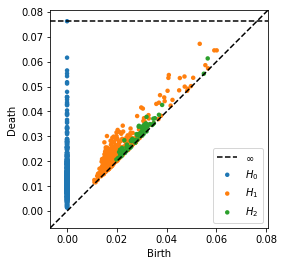

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

posterior = fit.extract()
bayes_data = np.stack([posterior['P1'], posterior['P2'], posterior['Pi']])
bayes_data = np.swapaxes(bayes_data, 0, 1)

bayes_pd = ripser(bayes_data[0:800], maxdim = 2)

plot_diagrams(bayes_pd['dgms'])

#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(posterior['P1'], posterior['P2'], posterior['Pi'], c = 'b', marker='o')
#plt.show()

1000


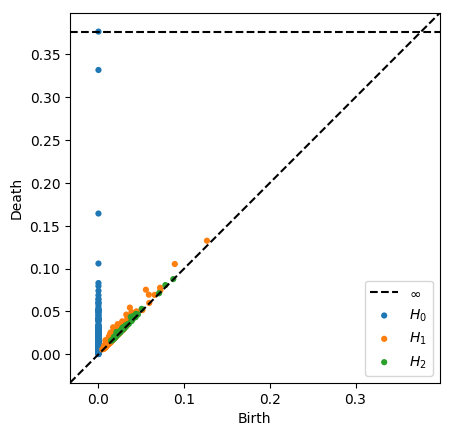

In [6]:
print(len(e203kBS))

bs_pd = ripser(e203kBS[0:800], maxdim = 2)
plot_diagrams(bs_pd['dgms'])


In [19]:
#Calculate the bottleneck distance between two (multi-dimensional) PDs

def bottleneck_distance(dgm1, dgm2):
  dim = len(dgm1)
  
  distance = 0
  
  for i in range(dim):
    dgm1_this_dim = dionysus.Diagram(dgm1[i])
    dgm2_this_dim = dionysus.Diagram(dgm2[i])

    distance += dionysus.bottleneck_distance(dgm1_this_dim, dgm2_this_dim)
    
  return distance

bottleneck_distance(bs_pd['dgms'], bayes_pd['dgms'])

0.17797183711081743